In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl

# set color cycle to gradient
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.viridis(np.linspace(0.5, 1, 5)))

In [3]:
import pandas as pd

# Load the dataset
columns = [
    'Family Name', 
    'Variation',
    'Algorithm Name', 
    'Year',
    'Looked at?',
    'Relevant?',
    'Time Complexity Class',
    'Approximation Factor Class (Mult)', 
    'Approximation Factor Class (Add)',
    'Approximation Type (additive/multiplicative)',	
    'Parametrized Approximation?',
    'Type of PTAS (if PTAS)',
    'Parallel?',
    'Quantum?'
]
approximation_algorithms = pd.read_csv('approximation_algorithms.csv', usecols=columns)

# Clean and prepare the data
# drop Looked at? == 0.001
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0.001']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0']
# drop Relevant? == 0
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != 0]
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != '0']

# filter out parallel algorithms
approximation_algorithms = approximation_algorithms[approximation_algorithms['Parallel?'] != '1']

approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != '1']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != 1]


approximation_algorithms['Year'] = pd.to_numeric(approximation_algorithms['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
approximation_algorithms.dropna(subset=['Year'], inplace=True)
approximation_algorithms['Year'] = approximation_algorithms['Year'].astype(int)

for col in ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']:
    # Extract complete numbers from the string including the decimal part
    approximation_algorithms[col] = pd.to_numeric(approximation_algorithms[col].astype(str).str.extract(r'(\d+\.\d+|\d+)')[0], errors='coerce')
    approximation_algorithms[col] = approximation_algorithms[col].replace(0, 99999)

# Sort the DataFrame for correct group-wise comparison
approximation_algorithms.sort_values(by=['Family Name', 'Variation', 'Year'], inplace=True)

approximation_algorithms['Improvement'] = 0
# Identify improvements
def identify_improvements(group):
    # Ensure necessary columns are present
    necessary_columns = ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']
    if not all(col in group.columns for col in necessary_columns):
        raise ValueError("Missing one or more necessary columns")

    # Initialize 'Improvement' column and 'Best_' columns safely
    group['Improvement'] = 0
    for col in necessary_columns:
        group['Best_' + col] = 999999

    # Initialize best values for the first row
    for col in necessary_columns:
        group['Best_' + col].iat[0] = group[col].iat[0]
        group['Improvement'].iat[0] = 1

    # Compute best values and track improvements
    for i in range(1, len(group)):
        for col in necessary_columns:
            previous_best = group['Best_' + col].iat[i - 1]
            current_value = group[col].iat[i]

            if current_value < previous_best:
                group['Best_' + col].iat[i] = current_value
                group['Improvement'].iat[i] = 1
            else:
                group['Best_' + col].iat[i] = previous_best

    # Drop helper columns
    drop_cols = ['Best_' + col for col in necessary_columns]
    group.drop(columns=drop_cols, inplace=True)

    return group


approximation_algorithms = approximation_algorithms.groupby(['Family Name', 'Variation']).apply(identify_improvements)

approximation_algorithms['Improvement'] = approximation_algorithms['Improvement'].astype(int)

approximation_algorithms


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12947/1497743113.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group['Best_' + col].iat[0] = group[col].iat[0]
/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12947/1497743113.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.04' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group['Best_' + col].iat[0] = group[col].iat[0]
/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12947/1497743113.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.01' has dtype incompatible with int64, please explicitly cast to a compatible

Family Name  \
Family Name                     Variation                                                                                 
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 153  All-Pairs Shortest Paths (APSP)   
                                                                                   154  All-Pairs Shortest Paths (APSP)   
                                                                                   155  All-Pairs Shortest Paths (APSP)   
                                                                                   156  All-Pairs Shortest Paths (APSP)   
                                                                                   157  All-Pairs Shortest Paths (APSP)   
...                                                                                                                 ...   
The Vertex Cover Problem        The Vertex Cover Size Problem, Sparse (Approxim... 770         The Vertex Cover Problem   
                                                                                   772         The Vertex Cover Problem   
Wiener Index                    Minimum Wiener Connector problem                   918                     Wiener Index   
                                                                                   917                     Wiener Index   
                                                                                   919                     Wiener Index   

                                                                                       Looked at?  \
Family Name                     Variation                                                           
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 153          1   
                                                                                   154          1   
                                                                                   155          1   
                                                                                   156          1   
                                                                                   157          1   
...                                                                                           ...   
The Vertex Cover Problem        The Vertex Cover Size Problem, Sparse (Approxim... 770          1   
                                                                                   772          1   
Wiener Index                    Minimum Wiener Connector problem                   918          1   
                                                                                   917          1   
                                                                                   919          1   

                                                                                       Relevant?  \
Family Name                     Variation                                                          
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 153         1   
                                                                                   154         1   
                                                                                   155         1   
                                                                                   156         1   
                                                                                   157         1   
...                                                                                          ...   
The Vertex Cover Problem        The Vertex Cover Size Problem, Sparse (Approxim... 770         1   
                                                                                   772         1   
Wiener Index                    Minimum Wiener Connector problem                   918         1   
                                                                                   917        

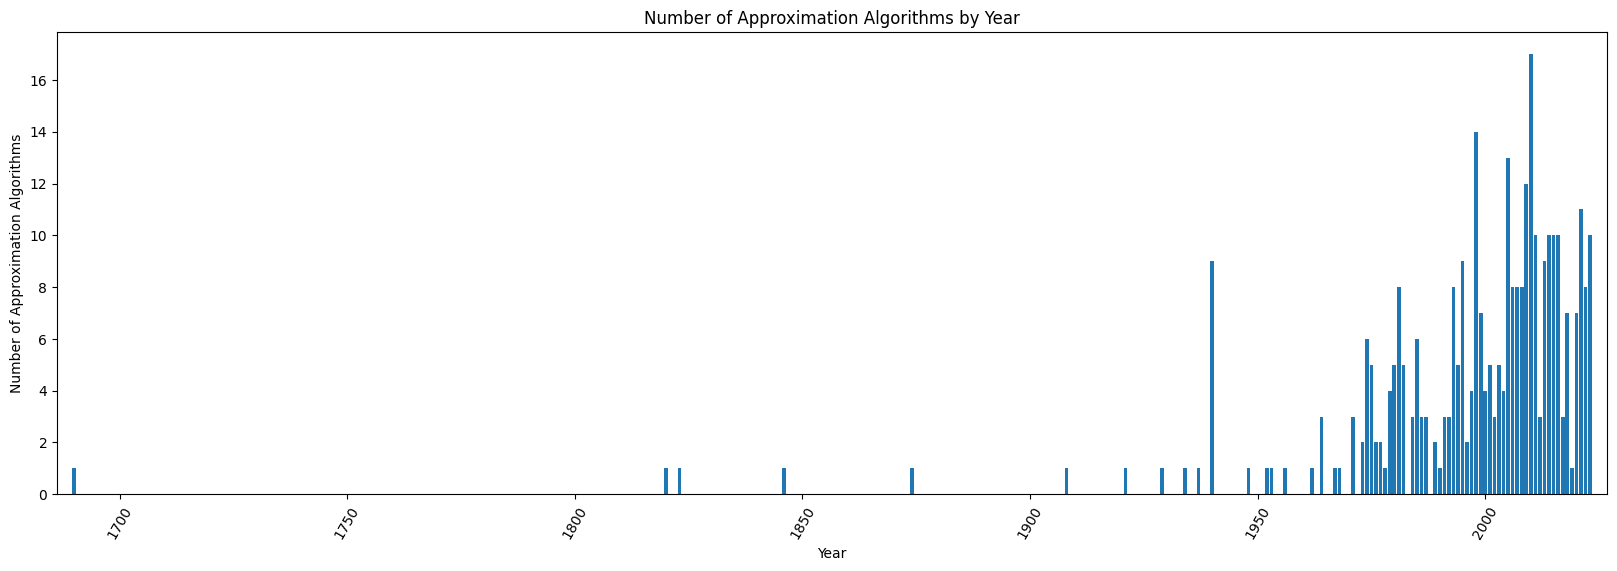

In [4]:
# Plot number of approximation algorithms by year
data = approximation_algorithms.copy()


data = data.groupby(['Year']).size()

fig, ax = plt.subplots()
bar_container = ax.bar(data.index, data.values)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year')
plt.show()

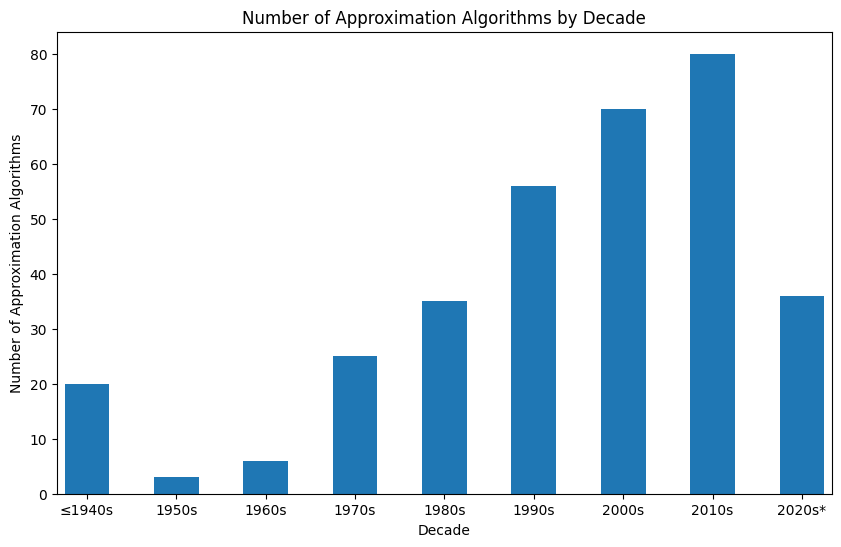

In [5]:
# Plot number of approximation algorithms by decade
data = approximation_algorithms.copy()


data = data.groupby(data['Year'] // 10 * 10).size()

# merge all year <= 1930 into 1930
data[1940] = data.loc[:1940].sum()
data = data.drop(data.loc[:1939].index)







fig, ax = plt.subplots()

bar_container = ax.bar(data.index, data.values, width=5)

# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)



ax.set_xticks(data.index)
ax.set_xticklabels(['≤1940s'] + ['2020s*' if year == 2020 else str(year) + 's' for year in data.index[1:]])

ax.set_xlabel('Decade')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Decade')
plt.show()
# 2020s*


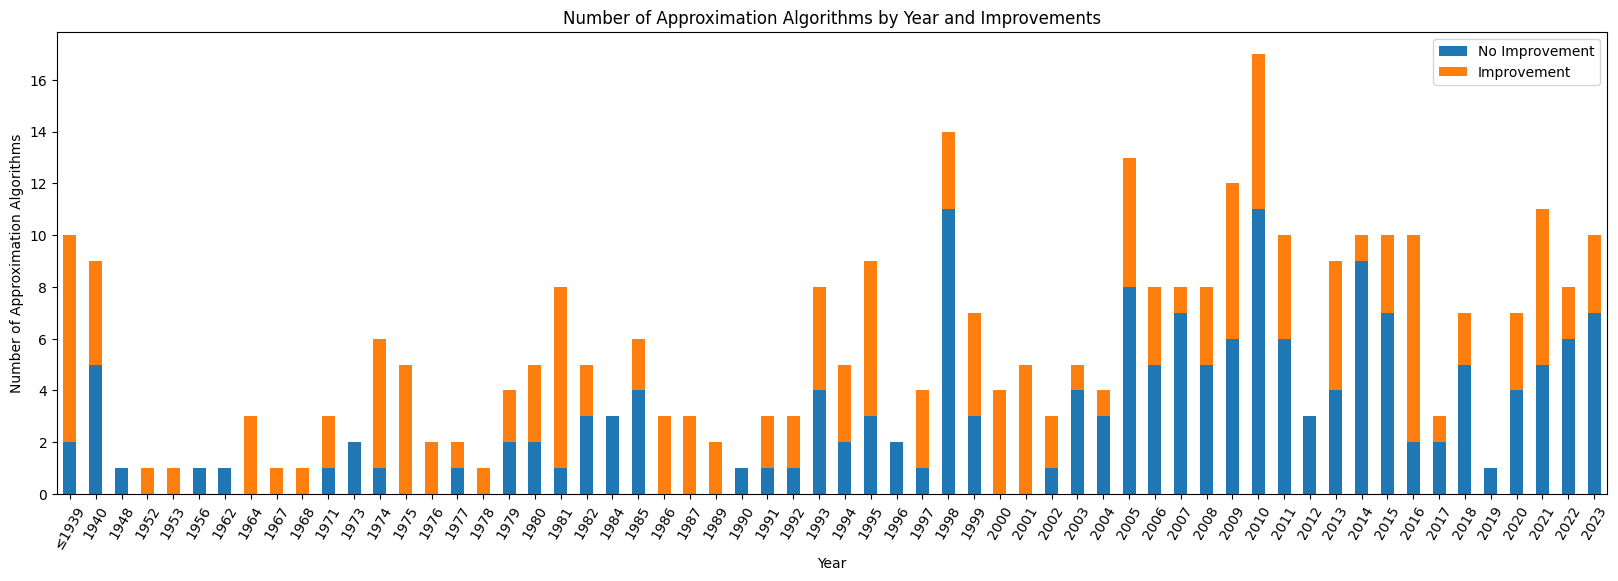

In [6]:
# Plot number of approximation algorithms by year and improvements
data = approximation_algorithms.copy()



# if year < 1930, set year to 1930
data.loc[data['Year'] < 1939, 'Year'] = 1939


data = data.groupby(['Year', 'Improvement']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)
ax.set_xticklabels(['≤1939'] + [str(year)  for year in data.index[1:]])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year and Improvements')

# legent for the plot
plt.legend(['No Improvement', 'Improvement'])

plt.show()






Improvement   0   1
Year               
1940         12   8
1950          2   1
1960          5   1
1970         18   7
1980         22  13
1990         27  29
2000         31  39
2010         30  50
2020         35  55


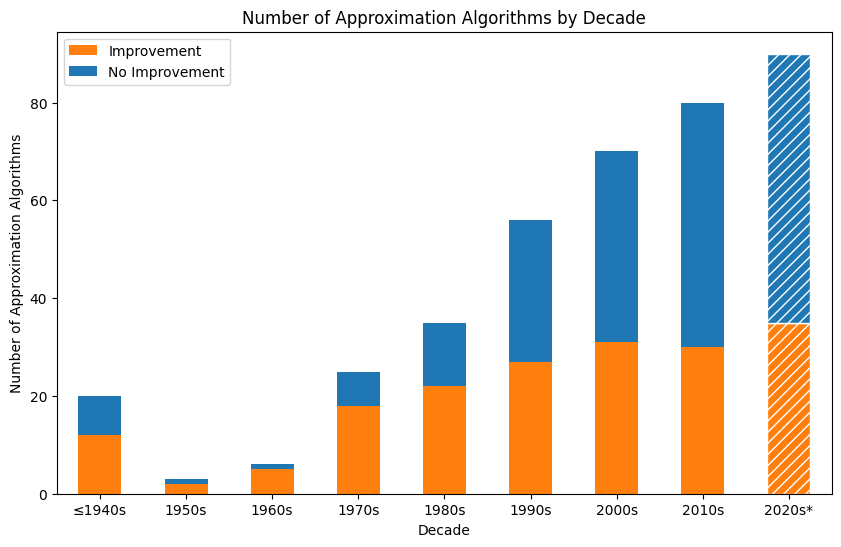

In [29]:
# Plot number of approximation algorithms by decade and improvements
data = approximation_algorithms.copy()

data.loc[data['Year'] < 1940, 'Year'] = 1940
data = data.groupby([data['Year'] // 10 * 10, 'Improvement']).size().unstack().fillna(0)
data[0], data[1] = data[1], data[0]

# multiply 2020 by 2.5
data.loc[2020] = data.loc[2020] * 2.5

print(data)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax, color = ['tab:orange', 'tab:blue'])
# set figure size
fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

# hatch last bar
ax.patches[-1].set_hatch('///')
ax.patches[8].set_hatch('///')

ax.patches[-1].set_edgecolor('white')
ax.patches[8].set_edgecolor('white')


ax.set_xlabel('Decade')
ax.set_xticklabels(['≤1940s'] + ['2020s*' if year == 2020 else str(year) + 's'  for year in data.index[1:]])

ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Decade')

# legent for the plot
plt.legend(['Improvement', 'No Improvement'])

plt.show()

# New Graph




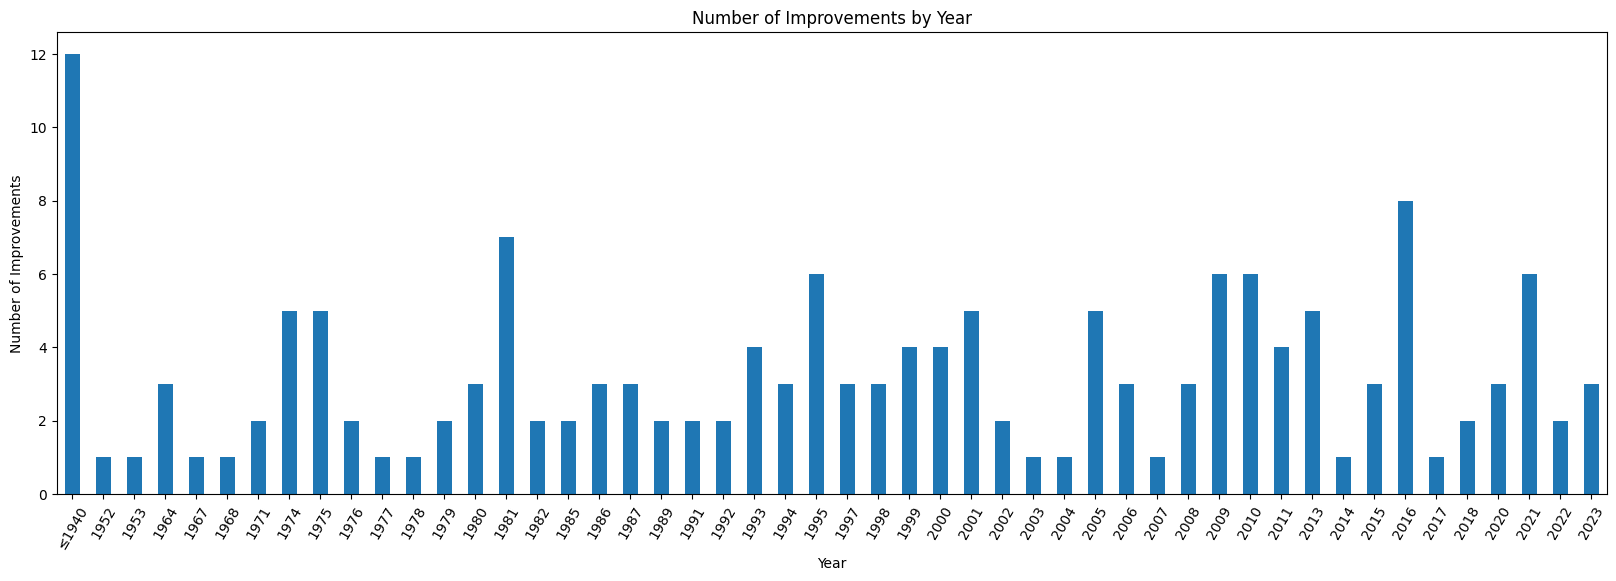

In [8]:
# Plot number of improvements by year
data = approximation_algorithms.copy()

data.loc[data['Year'] < 1940, 'Year'] = 1940

        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(['Year']).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels(['≤1940'] + [str(year)  for year in data.index[1:]])

ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


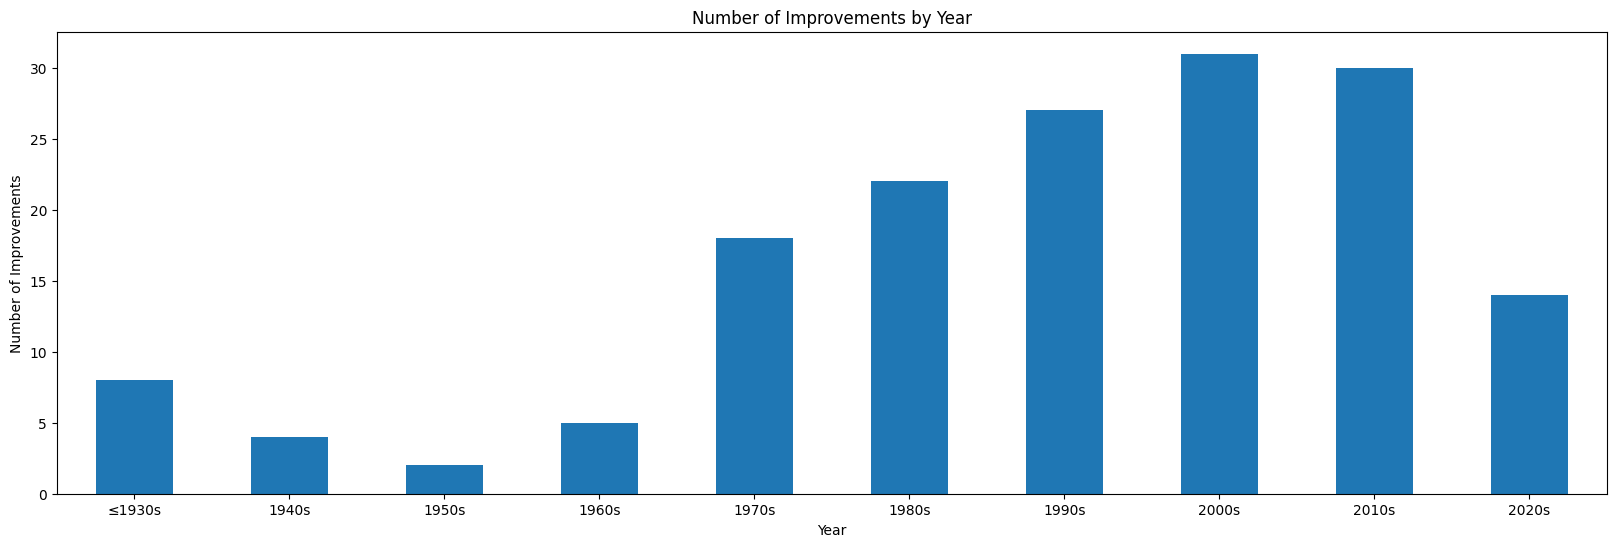

In [9]:
# Plot number of improvements by decade
data = approximation_algorithms.copy()

data.loc[data['Year'] < 1930, 'Year'] = 1930

        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(data['Year'] // 10 * 10).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels(['≤1930s'] + [str(year) + 's'  for year in data.index[1:]])

ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12947/2876456516.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 1 if x > 0 else 0)


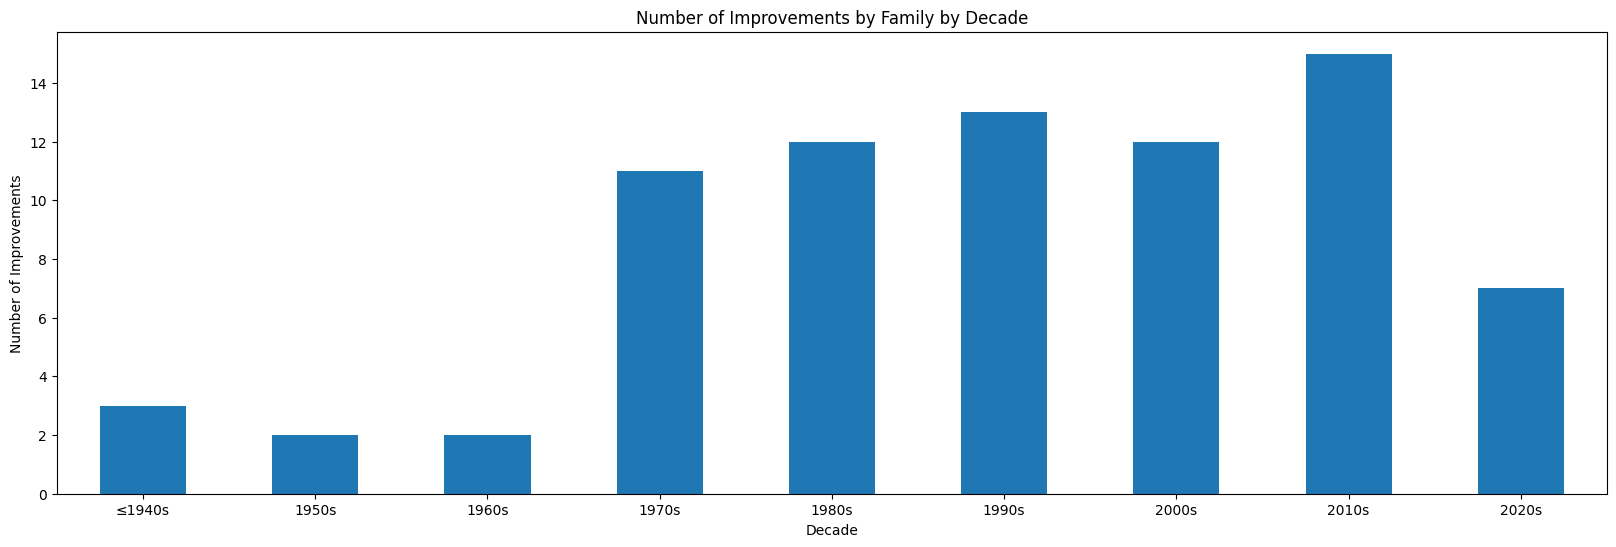

In [10]:
# Plot number of improvements by Family by decade
data = approximation_algorithms.copy()

data.loc[data['Year'] < 1940, 'Year'] = 1940


# drop column Family Name
data = data.drop(columns=['Family Name'])
data = data[data['Improvement'] == 1]

# group by family name
data = data.groupby(['Year', 'Family Name']).size().unstack().fillna(0)

data = data.groupby(data.index // 10 * 10).sum()
# if value > 0, set value to 1
data = data.applymap(lambda x: 1 if x > 0 else 0)

# group by decade

# sum all family name
data['Total'] = data.sum(axis=1)


# plot total per decade
fig, ax = plt.subplots()
data['Total'].plot(kind='bar', stacked=True, ax=ax)
# set figure size

fig.set_size_inches(20, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Decade')
ax.set_xticklabels(['≤1940s'] + [str(year) + 's'  for year in data.index[1:]])

ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Family by Decade')
plt.show()


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12947/3885983166.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 1 if x > 0 else 0)


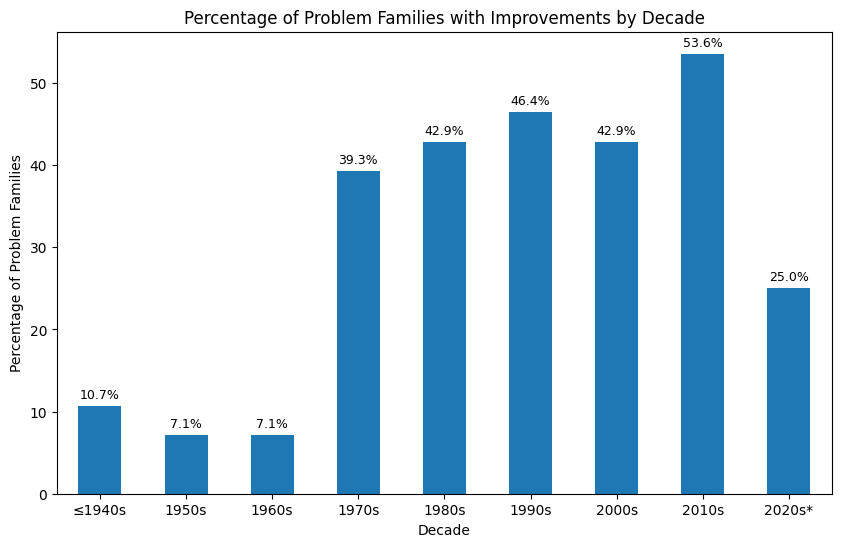

In [11]:
# Plot number of improvements by Family by decade
data = approximation_algorithms.copy()

data.loc[data['Year'] < 1940, 'Year'] = 1940


# drop column Family Name
data = data.drop(columns=['Family Name'])
data = data[data['Improvement'] == 1]

# group by family name
data = data.groupby(['Year', 'Family Name']).size().unstack().fillna(0)

data = data.groupby(data.index // 10 * 10).sum()
# if value > 0, set value to 1
data = data.applymap(lambda x: 1 if x > 0 else 0)

# group by decade

# sum all family name
data['Total'] = data.sum(axis=1)

# count unique family name
n_family = approximation_algorithms['Family Name'].nunique()

# total/ n_family
data['Total'] = data['Total'] / n_family *100


# plot total per decade
fig, ax = plt.subplots()
data['Total'].plot(kind='bar', stacked=True, ax=ax)
# set figure size

fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Decade')
ax.set_xticklabels(['≤1940s'] + ['2020s*' if year == 2020 else str(year) + 's'  for year in data.index[1:]])

# add percentage to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x()  + p.get_width() / 2., p.get_height() + 0.5),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.set_ylabel('Percentage of Problem Families')
ax.set_title('Percentage of Problem Families with Improvements by Decade')
plt.show()


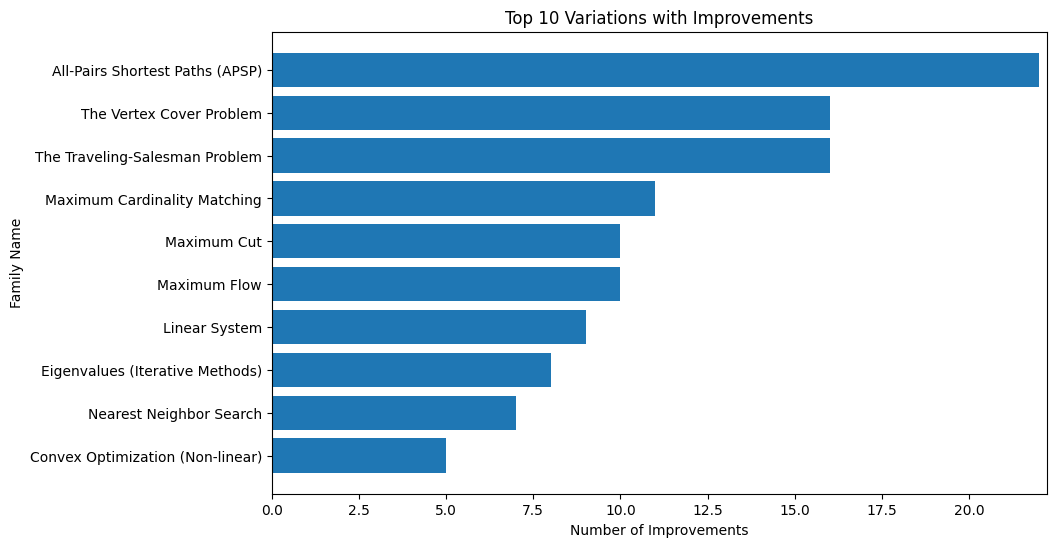

In [12]:
# Plot number of improvements by variation
data = approximation_algorithms.copy()


# variation with more improvements
data = data[data['Improvement'] == 1]

# number of improvements by variation
data = data['Family Name'].value_counts()

# top 10
data = data.head(10)

fig, ax = plt.subplots()
bar_container = ax.barh(data.index, data.values)

# reverse the order of the y-axis
ax.invert_yaxis()
# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)

ax.set_ylabel('Family Name')

ax.set_xlabel('Number of Improvements')

ax.set_title('Top 10 Variations with Improvements')

plt.show()



In [13]:
data = approximation_algorithms.copy()

# filter for Maximum Flow
data = data[data['Variation'] == 'Approximate Maximum Flow']
data

Family Name Looked at? Relevant?  \
Family Name  Variation                                                        
Maximum Flow Approximate Maximum Flow 32  Maximum Flow          1         1   
                                      19  Maximum Flow          1         1   
                                      18  Maximum Flow          1         1   
                                      20  Maximum Flow          1         1   
                                      21  Maximum Flow          1         1   
                                      22  Maximum Flow          1         1   
                                      23  Maximum Flow          1         1   
                                      24  Maximum Flow          1         1   
                                      25  Maximum Flow          1         1   
                                      26  Maximum Flow          1         1   
                                      27  Maximum Flow          1         1   
                                      28  Maximum Flow          1         1   
                                      34  Maximum Flow          1         1   

                                                         Variation  \
Family Name  Variation                                               
Maximum Flow Approximate Maximum Flow 32  Approximate Maximum Flow   
                                      19  Approximate Maximum Flow   
                                      18  Approximate Maximum Flow   
                                      20  Approximate Maximum Flow   
                                      21  Approximate Maximum Flow   
                                      22  Approximate Maximum Flow   
                                      23  Approximate Maximum Flow   
                                      24  Approximate Maximum Flow   
                                      25  Approximate Maximum Flow   
                                      26  Approximate Maximum Flow   
                                      27  Approximate Maximum Flow   
                                      28  Approximate Maximum Flow   
                                      34  Approximate Maximum Flow   

                                                                             Algorithm Name  \
Family Name  Variation                                                                        
Maximum Flow Approximate Maximum Flow 32                             Karger (Corollary 5.4)   
                                      19                                             Karger   
                                      18                                      Goldberg, Rao   
                                      20  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      21  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      22  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      23                    Lee, Rao, Srivastava (Remark 4)   
                                      24                                            Sherman   
                                      25                     Kelner, Lee, Orecchia, Sidford   
                                      26                                               Peng   
                                      27                                            Sherman   
                                      28                                      Sidford, Tian   
                                      34                             Kathuria, Liu, Sidford   

                                          Year  Time Complexity Class  \
Family Name  Variation                                                  
Maximum Flow Approximate Maximum Flow 32  1994                   7.00   
                                      19  1997                   5.50   
                                      18  1998                   6.01   
               